# Dependencies

In [84]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold

# Set seeds to make the experiment more reproducible.
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
seed = 0
seed_everything(seed)

%matplotlib inline
sns.set(style="white")
warnings.filterwarnings("ignore")

# Load data

In [85]:
columns = ["id_code", "level"]

data_1 = pd.read_csv("../train.csv", header=None)
data_2 = pd.read_csv("../trainLabels.csv", header=None)

data_1 = data_1.drop(0)
data_1.columns = columns
data_2.columns = columns

data_1["id_code"] = data_1["id_code"].apply(lambda x: x + ".png")
data_2["id_code"] = data_2["id_code"].apply(lambda x: x + ".jpeg")

diag_0 = data_2[data_2['level'] == 0].sample(frac=0.3, random_state=seed)
diag_oth = data_2[data_2['level'] != 0]
data_2 = diag_0.append(diag_oth)

data = pd.concat([data_1, data_2])
data = data.sample(frac = 1)
data = data.reset_index()
data = data.loc[:, ~data.columns.str.contains('index')]
data.columns = columns
data["level"] = pd.to_numeric(data["level"], downcast='integer')

display(data.head())
print(len(data))



,id_code,level
0,19462_left.jpeg,1
1,38e0e28d35d3.png,1
2,20985_right.jpeg,2
3,40728_left.jpeg,0
4,13031_right.jpeg,1


20721


# 5-Fold split

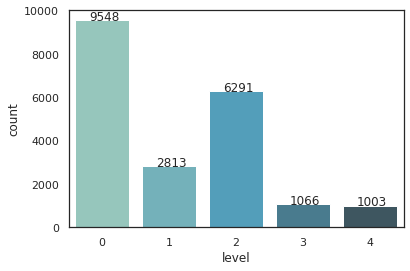

In [86]:
ax = sns.countplot(x="level", data=data, palette="GnBu_d")
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x()+0.2, p.get_height()+3))

In [87]:
test = data.tail(2000)
data = data.drop(test.index)

test = test.loc[:, ~test.columns.str.contains('index')]
test = test.reset_index()
test = test.loc[:, ~test.columns.str.contains('index')]
display(len(test))
test.to_csv("../imbalance_data/test.csv", index=None)



2000

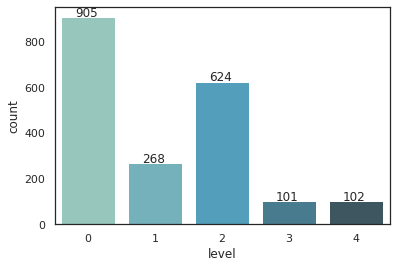

In [88]:
ax = sns.countplot(x="level", data=test, palette="GnBu_d")
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x()+0.2, p.get_height()+3))

In [89]:
data = data.reset_index()
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
for fold_n, (trn_idx, val_idx) in enumerate(folds.split(data, data['level'])):
    print('Fold: %s, Train size: %s, Validation size %s' % 
          (fold_n, len(trn_idx), len(val_idx)))
    data[('fold_%s' % fold_n)] = 0
    data[('fold_%s' % fold_n)].loc[trn_idx] = 'train'
    data[('fold_%s' % fold_n)].loc[val_idx] = 'validation'
    
display(data.head())

Fold: 0, Train size: 14976, Validation size 3745
Fold: 1, Train size: 14977, Validation size 3744
Fold: 2, Train size: 14977, Validation size 3744
Fold: 3, Train size: 14977, Validation size 3744
Fold: 4, Train size: 14977, Validation size 3744


,index,id_code,level,fold_0,fold_1,fold_2,fold_3,fold_4
0,0,19462_left.jpeg,1,train,train,validation,train,train
1,1,38e0e28d35d3.png,1,validation,train,train,train,train
2,2,20985_right.jpeg,2,train,train,validation,train,train
3,3,40728_left.jpeg,0,train,train,train,validation,train
4,4,13031_right.jpeg,1,train,validation,train,train,train


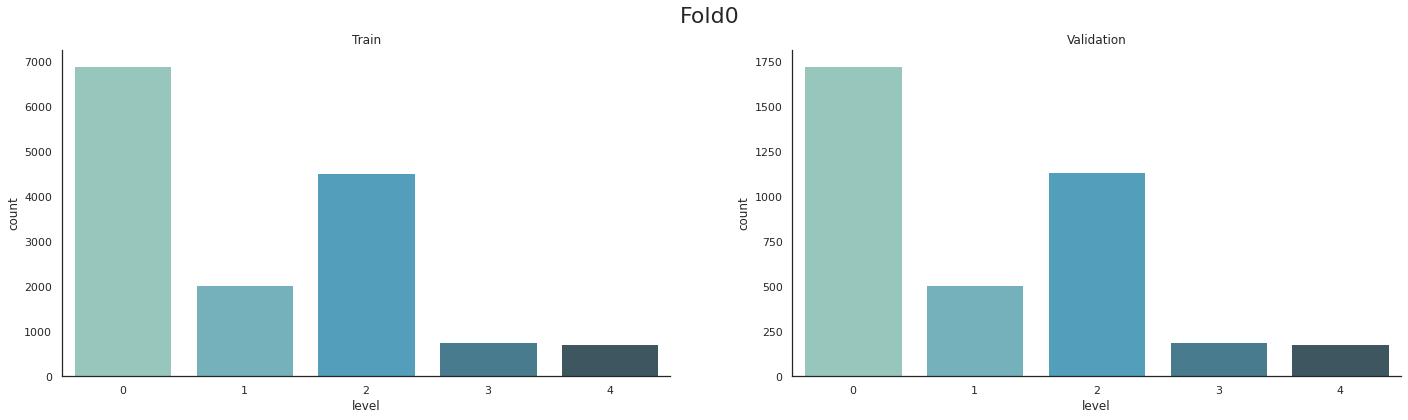

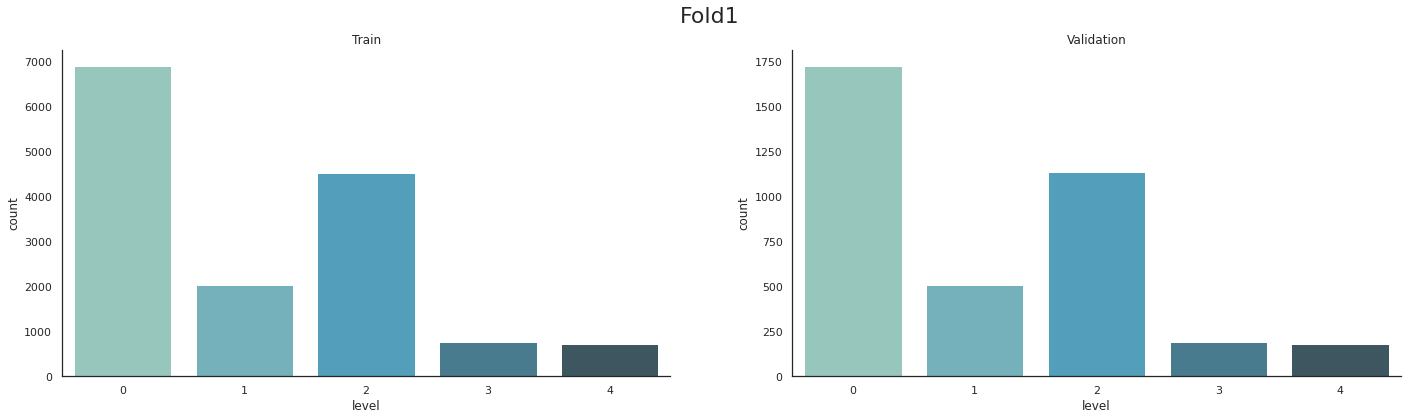

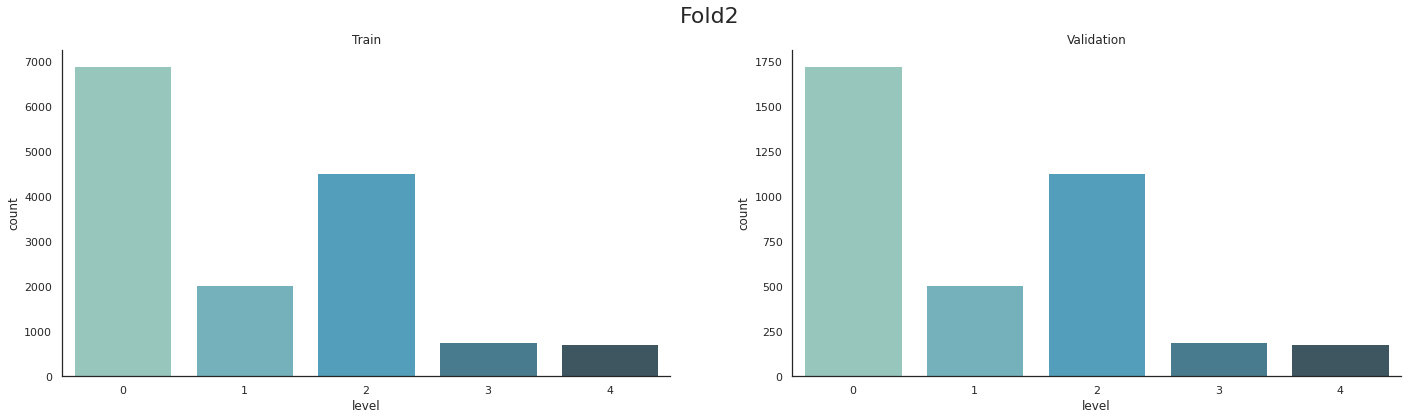

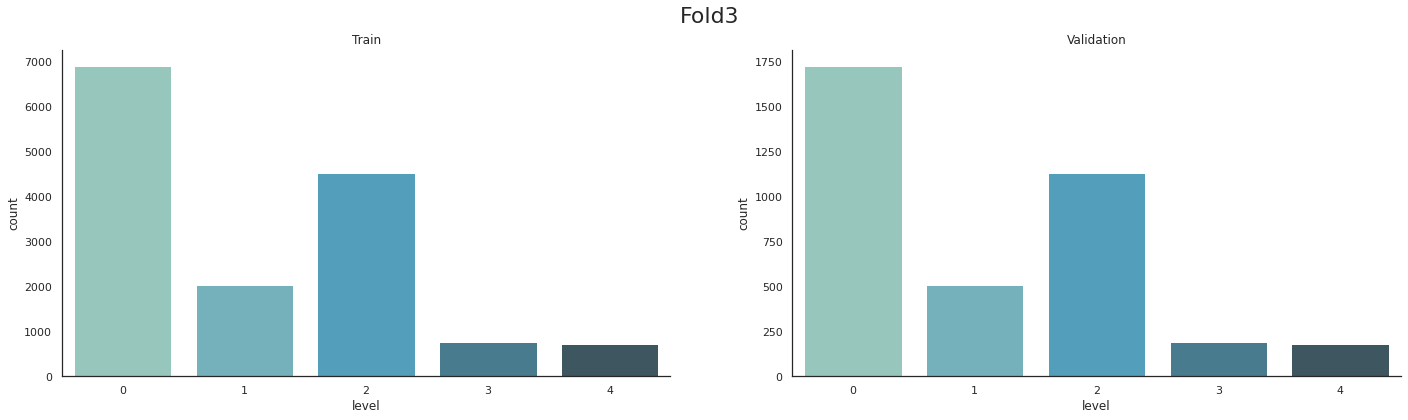

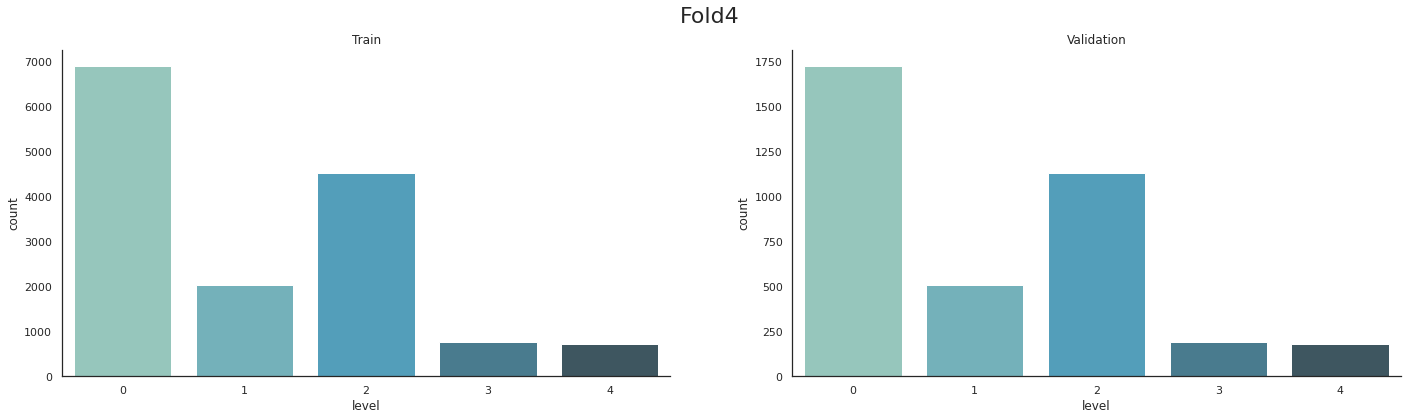

In [90]:
for fold_n, (trn_idx, val_idx) in enumerate(folds.split(data, data['level'])):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 6))
    fig.suptitle('Fold%s'%fold_n, fontsize=22)    
    sns.countplot(x="level", data=data[data[('fold_%s' % fold_n)] == 'train'], palette="GnBu_d", ax=ax1).set_title('Train')
    sns.countplot(x="level", data=data[data[('fold_%s' % fold_n)] == 'validation'], palette="GnBu_d", ax=ax2).set_title('Validation')
    sns.despine()
    plt.show()

In [91]:
data.to_csv("../imbalance_data/train.csv", index=None)
